In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from data import make_grid

In [3]:
birds_pd = pd.read_csv('data/gen_data/birds_top.csv')
birds_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740874 entries, 0 to 740873
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   species           740874 non-null  object 
 1   decimalLatitude   740874 non-null  float64
 2   decimalLongitude  740874 non-null  float64
 3   countryCode       740874 non-null  object 
 4   recordedBy        740874 non-null  object 
dtypes: float64(2), object(3)
memory usage: 28.3+ MB


In [4]:
world_map = gpd.read_file("data/source_data/world-administrative-boundaries.geojson")
world_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   geo_point_2d              256 non-null    object  
 1   iso3                      238 non-null    object  
 2   status                    255 non-null    object  
 3   color_code                255 non-null    object  
 4   name                      256 non-null    object  
 5   continent                 256 non-null    object  
 6   region                    252 non-null    object  
 7   iso_3166_1_alpha_2_codes  236 non-null    object  
 8   french_short              256 non-null    object  
 9   geometry                  256 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 20.1+ KB


<Axes: >

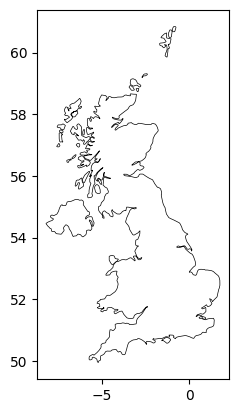

In [5]:
uk_map = world_map[world_map['iso_3166_1_alpha_2_codes'] == 'GB']

def uk_outline():
    return uk_map.geometry.boundary.plot(color="black", linewidth=0.5)

uk_outline()

In [6]:
grid = make_grid("GB", 0.1)
grid.info()

Matching birds to grid cells: 

 98%|█████████▊| 98/100 [00:06<00:00, 16.40it/s]/Users/leoware/Documents/ns166_final_analysis/data/make_grid.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[spec] = counts
100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Columns: 106 entries, lat to Vanellus vanellus
dtypes: float64(6), int64(100)
memory usage: 2.7 MB


# Justifying the Causal Model

### Claim: Spacial Heterogeneity in Sampling

In [7]:
birds_uk = birds_pd[birds_pd['countryCode'] == 'GB']
birds_uk = gpd.GeoDataFrame(birds_uk, geometry=gpd.points_from_xy(
    birds_uk['decimalLongitude'], birds_uk['decimalLatitude']))

(-8.668374099999946, 2.2591160999999973, 49.34172555, 61.391025450000036)

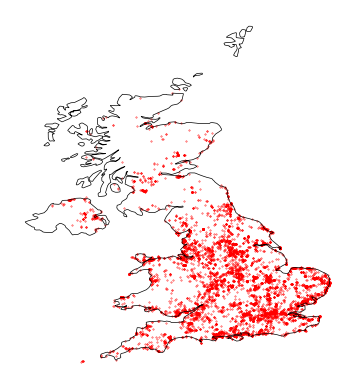

In [8]:
birds_uk.sample(10000).plot(ax=uk_outline(), color='red', markersize=0.1)
plt.axis('off')

(-8.66772549999995, 2.2454955000000494, 49.410877500000076, 61.387732500000034)

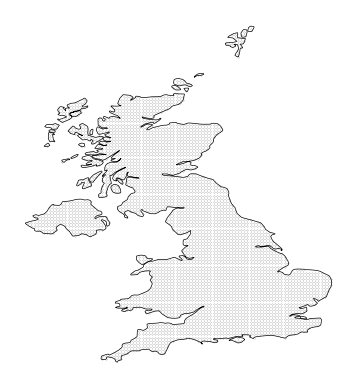

In [9]:


grid_gpd = gpd.GeoDataFrame(grid, geometry=gpd.points_from_xy(
    grid['lon'], grid['lat']))
grid_gpd.plot(ax=uk_outline(), color='black', markersize=0.01)


plt.axis("off")

### Claim: Population is related to sampling density

In [10]:
id_col = ["lat", "lon"]
cov_col = ['avg_temp', 'avg_min_month', 'avg_max_month', 'pop_density']
target_col = grid.columns.difference(id_col).difference(cov_col)

grid["total_birds"] = grid[target_col].sum(axis=1)
target_col = grid.columns.difference(id_col).difference(cov_col)
grid["total_birds"].describe()

count     3349.000000
mean       203.562855
std        725.838626
min          0.000000
25%          1.000000
50%         19.000000
75%        122.000000
max      21430.000000
Name: total_birds, dtype: float64

In [11]:
stats.linregress(grid.pop_density, grid.total_birds)

LinregressResult(slope=-0.46318590647053426, intercept=232.62684065693654, rvalue=-0.09877094324159646, pvalue=1.0173870598405096e-08, stderr=0.08066208707287144, intercept_stderr=13.470062863393341)

In [12]:
pop_data_pd = pd.read_csv("data/gen_data/pop_data.csv")
pop_data = gpd.GeoDataFrame(pop_data_pd, geometry=gpd.points_from_xy(
    pop_data_pd['lon'], pop_data_pd['lat']))
pop_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70123 entries, 0 to 70122
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lat          70123 non-null  float64 
 1   lon          70123 non-null  float64 
 2   pop_density  70123 non-null  float64 
 3   geometry     70123 non-null  geometry
dtypes: float64(3), geometry(1)
memory usage: 2.1 MB


In [13]:
uk_shape = uk_map.geometry.values[0]
# uk_pop_data = pop_data[pop_data.geometry.values.within(uk_shape)]
uk_pop_data = pop_data[pop_data.geometry.values.within(uk_shape.envelope)]
uk_pop_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 16 entries, 57641 to 59119
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   lat          16 non-null     float64 
 1   lon          16 non-null     float64 
 2   pop_density  16 non-null     float64 
 3   geometry     16 non-null     geometry
dtypes: float64(3), geometry(1)
memory usage: 640.0 bytes


<Axes: >

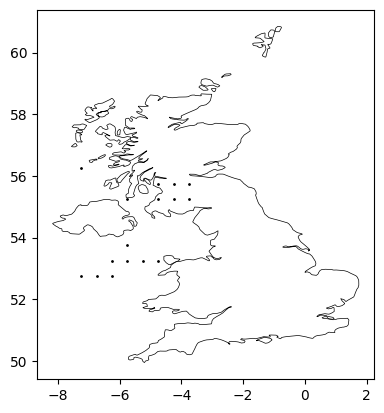

In [14]:
uk_pop_data.plot(ax=uk_outline(), color='black', markersize=1)

# redo pop

In [15]:
top_n = 5
cities = pd.read_csv("data/source_data/gb.csv")
cities = cities.sort_values(by="population", ascending=False)[["city", "lat", "lng", "population"]]
cities.head(top_n)

,city,lat,lng,population
0,London,51.5072,-0.1275,11262000
1,Birmingham,52.4800,-1.9025,2919600
2,Manchester,53.4794,-2.2453,2705000
3,Liverpool,53.4075,-2.9919,864122
4,Portsmouth,50.8058,-1.0872,855679


In [16]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 680 entries, 0 to 679
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        680 non-null    object 
 1   lat         680 non-null    float64
 2   lng         680 non-null    float64
 3   population  680 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 26.6+ KB


In [35]:
dist = np.sqrt(
    (grid.lat.values.reshape(-1, 1) - cities.lat.values.reshape(1, -1))**2 +
    (grid.lon.values.reshape(-1, 1) - cities.lng.values.reshape(1, -1))**2
)

def pop_adj(disc):
    return ((disc ** dist) * cities.population.values.reshape(1, -1)).sum(axis=1)

def cost(disc, resample=True):
    disc_df = pd.DataFrame({"pop_proxy": pop_adj(disc), "birds": grid.total_birds})
    if resample:
        disc_df = disc_df.sample(frac=1, replace=True)
    res = stats.linregress(disc_df.pop_proxy, disc_df.birds)
    return -(res.rvalue ** 2)

res = optimize.minimize(cost, 0.1)
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.0856968479316545
        x: [ 1.001e-01]
      nit: 3
      jac: [-1.382e+05]
 hess_inv: [[ 3.091e-15]]
     nfev: 60
     njev: 22

In [49]:
np.random.seed(42)

n_boots = 100

disc_res = []
r2_res = []
for _ in tqdm(range(n_boots)):

    df = grid.sample(grid.shape[0], replace=True)
    dist = np.sqrt(
        (df.lat.values.reshape(-1, 1) - cities.lat.values.reshape(1, -1))**2 +
        (df.lon.values.reshape(-1, 1) - cities.lng.values.reshape(1, -1))**2
    )

    def pop_adj(disc):
        return ((disc ** dist) * cities.population.values.reshape(1, -1)).sum(axis=1)

    def cost(disc):
        res = stats.linregress(pop_adj(disc), df.total_birds)
        return -(res.rvalue ** 2)

    try:
        res = optimize.minimize(cost, 0.1, bounds=[(0, 1)])
        disc_res.append(res.x[0])
        r2_res.append(-res.fun)
    except ValueError:
        pass

print(f"success rate: {len(disc_res)} / {n_boots} = {len(disc_res) / n_boots:.2f}")

disc_res = np.array(disc_res)
print("discount:", disc_res.mean(), np.quantile(disc_res, 0.025), np.quantile(disc_res, 0.975))
r2_res = np.array(r2_res)
print("r2:", r2_res.mean(), np.quantile(r2_res, 0.025), np.quantile(r2_res, 0.975))

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

success rate: 93 / 100 = 0.93
discount: 0.5109102056334093 0.262769061825275 0.6692164036908115
r2: 0.05018055183296073 0.03415710103854906 0.06837533464759357


In [50]:
(disc_res > 0).mean()

1.0

In [51]:
1 / 101

0.009900990099009901